In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm
import plotly.express as px

from sentence_transformers import SentenceTransformer
import hdbscan

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

c:\Users\lucch\Desktop\thesis-datasec\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
def load_data(directory):
    data = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file))
            data.append(df)
    return pd.concat(data, ignore_index=True)

df = load_data('data/cic')
# Clean column names (in case of whitespace)
df.columns = df.columns.str.strip()

df = df[df['Label'] != 'BENIGN']

features = df.select_dtypes(include=[np.number]).copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
df = df.loc[features.index].copy()

100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


In [3]:
df.reset_index(drop=True, inplace=True)

In [4]:
df["Label"].value_counts()

Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [5]:
def group_attack_label(label):
    if label == "BENIGN":
        return "Benign"
    elif "DoS" in label or label == "DDoS":
        return "DoS/DDoS"
    elif "PortScan" in label:
        return "Scan"
    elif "Patator" in label:
        return "BruteForce"
    elif "Web Attack" in label:
        return "WebAttack"
    elif label in ["Bot", "Infiltration", "Heartbleed"]:
        return "Other"
    else:
        return "Unknown"

df['label_group'] = df['Label'].apply(group_attack_label)

In [6]:
df["label_group"].value_counts()

label_group
DoS/DDoS      379737
Scan          158804
BruteForce     13832
WebAttack       2180
Other           2003
Name: count, dtype: int64

In [7]:
df

Destination Port  Flow Duration  Total Fwd Packets  \
0                     80        1293792                  3   
1                     80        4421382                  4   
2                     80        1083538                  3   
3                     80       80034360                  8   
4                     80         642654                  3   
...                  ...            ...                ...   
556551                80       11512204                  8   
556552                80       11513325                  5   
556553                80       11509201                  7   
556554                80       11509095                  8   
556555                80       11512230                  5   

        Total Backward Packets  Total Length of Fwd Packets  \
0                            7                           26   
1                            0                           24   
2                            6                           26   
3                            4                           56   
4                            6                           26   
...                        ...                          ...   
556551                       5                          326   
556552                       5                          471   
556553                       6                          314   
556554                       5                          369   
556555                       5                          672   

        Total Length of Bwd Packets  Fwd Packet Length Max  \
0                             11607                     20   
1                                 0                      6   
2                             11601                     20   
3                             11601                     20   
4                             11607                     20   
...                             ...                    ...   
556551                        11632                    326   
556552                         3525                    471   
556553                        11632                    314   
556554                        11632                    369   
556555                         3525                    672   

        Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
0                           0                8.666667              10.263203   
1                           6                6.000000               0.000000   
2                           0                8.666667              10.263203   
3                           0                7.000000               5.656854   
4                           0                8.666667              10.263203   
...                       ...                     ...                    ...   
556551                      0               40.750000             115.258405   
556552                      0               94.200000             210.637604   
556553                      0               44.857143             118.680845   
556554                      0               46.125000             130.461201   
556555                      0              134.400000             300.527536   

        ...  Active Mean  Active Std  Active Max  Active Min   Idle Mean  \
0       ...          0.0         0.0           0           0         0.0   
1       ...          0.0         0.0           0           0         0.0   
2       ...          0.0         0.0           0           0         0.0   
3       ...        939.0         0.0         939         939  39300000.0   
4       ...          0.0         0.0           0           0         0.0   
...     ...          ...         ...         ...         ...         ...   
556551  ...        892.0         0.0         892         892   6507197.0   
556552  ...        918.0         0.0         918         918   6508582.0   
556553  ...        899.0         0.0         899         899   6503248.0   
556554  ...        914.0         0.0    

In [8]:
df = df.loc[:, ~df.columns.str.contains('bwd', case=False)]
df = df.loc[:, ~df.columns.str.contains('backward', case=False)]


In [9]:
import pickle
with open('data/grouped_df.pkl', 'rb') as f:
    grouped_df = pickle.load(f)
grouped_df

cic_Total Fwd Packets  cic_Total Length of Fwd Packets  \
0                         1.0                              0.0   
1                         1.0                              0.0   
2                         3.0                            239.0   
3                         1.0                              0.0   
4                         1.0                              0.0   
...                       ...                              ...   
339707                    1.0                            133.0   
339708                    1.0                             97.0   
339709                    1.0                              0.0   
339710                    1.0                             22.0   
339711                    1.0                              0.0   

        cic_Fwd Packet Length Mean  cic_Fwd Packet Length Min  \
0                         0.000000                        0.0   
1                         0.000000                        0.0   
2                        79.666667                        0.0   
3                         0.000000                        0.0   
4                         0.000000                        0.0   
...                            ...                        ...   
339707                  133.000000                      133.0   
339708                   97.000000                       97.0   
339709                    0.000000                        0.0   
339710                   22.000000                       22.0   
339711                    0.000000                        0.0   

        cic_Fwd Packet Length Max  cic_Fwd Packet Length Std  \
0                             0.0                   0.000000   
1                             0.0                   0.000000   
2                           147.0                  74.272023   
3                             0.0                   0.000000   
4                             0.0                   0.000000   
...                           ...                        ...   
339707                      133.0                   0.000000   
339708                       97.0                   0.000000   
339709                        0.0                   0.000000   
339710                       22.0                   0.000000   
339711                        0.0                   0.000000   

        cic_Packet Length Variance  cic_Flow IAT Mean  cic_Flow IAT Std  \
0                         0.000000                0.0          0.000000   
1                         0.000000                0.0          0.000000   
2                      5516.333333                1.0          1.732051   
3                         0.000000                0.0          0.000000   
4                         0.000000                0.0          0.000000   
...                            ...                ...               ...   
339707                    0.000000                0.0          0.000000   
339708                    0.000000                0.0          0.000000   
339709                    0.000000                0.0          0.000000   
339710                    0.000000                0.0          0.000000   
339711                    0.000000                0.0          0.000000   

        cic_Flow IAT Min  ...  dst_country_emb_1_first  \
0                    0.0  ...                 0.112963   
1                    0.0  ...                -0.004529   
2                    0.0  ...                 0.352385   
3                    0.0  ...                 0.112963   
4                    0.0  ...                 0.145555   
...                  ...  ...                      ...   
339707               0.0  ...                -0.030979   
339708               0.0  ...                 0.352385   
339709               0.0  ...                -0.147976   
339710               0.0  ...                -0.147976   
339711               0.0  ...                -0.017805   

        dst_country_emb_2_first  dst_country_emb_3_first  \
0      

In [10]:
cic_columns = grouped_df.filter(regex='^cic').columns
grouped_df = grouped_df[[col for col in grouped_df.columns if 'emb' not in col]]
grouped_df_cic = grouped_df[cic_columns]

In [ ]:
IAT = grouped_df.filter(regex="IAT*").columns
grouped_df[IAT].describe()

cic_Flow IAT Mean  cic_Flow IAT Std  cic_Flow IAT Min  \
count      339712.000000     339712.000000          339712.0   
mean            8.564092         10.940064               0.0   
std            36.784266         43.622244               0.0   
min             0.000000          0.000000               0.0   
25%             0.000000          0.000000               0.0   
50%             0.000000          0.000000               0.0   
75%             0.500000          0.577350               0.0   
max           550.500000        424.264069               0.0   

       cic_Flow IAT Max  cic_Fwd IAT Mean  cic_Fwd IAT Std  cic_Fwd IAT Max  \
count     339712.000000     339712.000000    339712.000000    339712.000000   
mean          20.435751          8.564092        10.940064        20.435751   
std           79.038769         36.784266        43.622244        79.038769   
min            0.000000          0.000000         0.000000         0.000000   
25%            0.000000          0.000000         0.000000         0.000000   
50%            0.000000          0.000000         0.000000         0.000000   
75%            1.000000          0.500000         0.577350         1.000000   
max          600.000000        550.500000       424.264069       600.000000   

       cic_Fwd IAT Min  cic_Fwd IAT Total  
count         339712.0      339712.000000  
mean               0.0          39.028156  
std                0.0         451.200207  
min                0.0           0.000000  
25%                0.0           0.000000  
50%                0.0           0.000000  
75%                0.0           2.000000  
max                0.0       86325.000000

In [ ]:
df[df.filter(regex="IAT").columns].describe()

Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Total  \
count   5.565560e+05  5.565560e+05  5.565560e+05  5.565560e+05   5.565560e+05   
mean    2.892205e+06  8.405503e+06  2.843157e+07  2.233378e+05   2.914620e+07   
std     5.563720e+06  1.229449e+07  4.150648e+07  3.838665e+06   4.233110e+07   
min     5.000000e-01  0.000000e+00  1.000000e+00 -1.300000e+01   0.000000e+00   
25%     4.900000e+01  0.000000e+00  4.900000e+01  2.000000e+00   0.000000e+00   
50%     4.659430e+04  7.881581e+04  2.758915e+05  5.000000e+00   8.350000e+03   
75%     6.578468e+06  2.290000e+07  8.350000e+07  4.800000e+01   8.410000e+07   
max     1.200000e+08  8.370000e+07  1.200000e+08  1.200000e+08   1.200000e+08   

       Fwd IAT Mean   Fwd IAT Std   Fwd IAT Max   Fwd IAT Min  
count  5.565560e+05  5.565560e+05  5.565560e+05  5.565560e+05  
mean   5.514674e+06  1.151668e+07  2.834528e+07  5.415419e+05  
std    9.928093e+06  1.729540e+07  4.156235e+07  6.737672e+06  
min    0.000000e+00  0.000000e+00  0.000000e+00 -1.200000e+01  
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
50%    4.013500e+03  1.989798e+03  8.002000e+03  1.000000e+00  
75%    1.190000e+07  3.020000e+07  8.350000e+07  1.800000e+01  
max    1.200000e+08  8.370000e+07  1.200000e+08  1.200000e+08

In [15]:
# removed IAT columns from grouped_df_cic as they are almost all 0
grouped_df_cic.drop(columns=grouped_df.filter(regex="IAT*").columns, inplace=True)

C:\Users\lucch\AppData\Local\Temp\ipykernel_19504\2415698787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic.drop(columns=grouped_df.filter(regex="IAT*").columns, inplace=True)


In [ ]:
import pandas as pd

feature_mapping = [
    ('Destination Port', 'cic_Destination Port'),
    ('Flow Duration', 'cic_Flow Duration'),
    ('Total Fwd Packets', 'cic_Total Fwd Packets'),
    ('Total Length of Fwd Packets', 'cic_Total Length of Fwd Packets'),
    ('Fwd Packet Length Max', 'cic_Fwd Packet Length Max'),
    ('Fwd Packet Length Min', 'cic_Fwd Packet Length Min'),
    ('Fwd Packet Length Mean', 'cic_Fwd Packet Length Mean'),
    ('Fwd Packet Length Std', 'cic_Fwd Packet Length Std'),
    ('Flow Bytes/s', 'cic_Flow Bytes/s'),
    ('Flow Packets/s', 'cic_Flow Packets/s'),
    ('Fwd Packets/s', 'cic_Fwd Packets/s'),
    ('Min Packet Length', 'cic_Min Packet Length'),
    ('Max Packet Length', 'cic_Max Packet Length'),
    ('Packet Length Mean', 'cic_Packet Length Mean'),
    ('Packet Length Std', 'cic_Packet Length Std'),
    ('Packet Length Variance', 'cic_Packet Length Variance'),
    ('Average Packet Size', 'cic_Average Packet Size'),
    ('Avg Fwd Segment Size', 'cic_Avg Fwd Segment Size')
]

rename_dict = {cic_name: new_name for new_name, cic_name in feature_mapping}
grouped_df_cic.rename(columns=rename_dict, inplace=True)

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_17140\2195592805.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic.rename(columns=rename_dict, inplace=True)


In [ ]:
columns = list(grouped_df_cic.columns)
columns.append("label_group")

In [ ]:
df = df[columns]
df

Total Fwd Packets  Total Length of Fwd Packets  \
0                       3                           26   
1                       4                           24   
2                       3                           26   
3                       8                           56   
4                       3                           26   
...                   ...                          ...   
556551                  8                          326   
556552                  5                          471   
556553                  7                          314   
556554                  8                          369   
556555                  5                          672   

        Fwd Packet Length Mean  Fwd Packet Length Min  Fwd Packet Length Max  \
0                     8.666667                      0                     20   
1                     6.000000                      6                      6   
2                     8.666667                      0                     20   
3                     7.000000                      0                     20   
4                     8.666667                      0                     20   
...                        ...                    ...                    ...   
556551               40.750000                      0                    326   
556552               94.200000                      0                    471   
556553               44.857143                      0                    314   
556554               46.125000                      0                    369   
556555              134.400000                      0                    672   

        Fwd Packet Length Std  Packet Length Variance  Flow IAT Mean  \
0                   10.263203            3.435231e+06   1.437547e+05   
1                    0.000000            0.000000e+00   1.473794e+06   
2                   10.263203            2.706820e+06   1.354422e+05   
3                    5.656854            6.192667e+06   7.275851e+06   
4                   10.263203            4.572452e+06   8.033175e+04   
...                       ...                     ...            ...   
556551             115.258405            7.361769e+06   9.593503e+05   
556552             210.637604            5.180836e+05   1.279258e+06   
556553             118.680845            3.449144e+06   9.591001e+05   
556554             130.461201            7.358407e+06   9.590912e+05   
556555             300.527536            5.260871e+05   1.279137e+06   

        Flow IAT Std  Flow IAT Min  ...  Packet Length Std  \
0       4.308658e+05             2  ...        1853.437529   
1       2.552043e+06           340  ...           0.000000   
2       3.777253e+05            41  ...        1645.241762   
3       2.110000e+07             6  ...        2488.507044   
4       2.268247e+05             3  ...        2138.329153   
...              ...           ...  ...                ...   
556551  2.262616e+06             1  ...        2713.257986   
556552  2.565153e+06            53  ...         719.780257   
556553  2.261842e+06            46  ...        1857.187221   
556554  2.262122e+06            47  ...        2712.638403   
556555  2.565060e+06             4  ...         725.318601   

        Average Packet Size  Avg Fwd Segment Size  Fwd IAT Mean   Fwd IAT Std  \
0               1163.300000              8.666667  3.735000e+02  5.239661e+02   
1                  7.500000              6.000000  1.473794e+06  2.552043e+06   
2               1291.888889              8.666667  6.491000e+03  8.165669e+03   
3                971.916667              7.000000  1.120000e+07  2.630000e+07   
4               1292.555556              8.666667  4.005000e+02  5.409367e+02   
...                     ...                   ...           ...           ...   
556551           919.846154             40.750000  9.301100e+05  2.460477e+06   
556552           399.600000             94.200000  1.628158e+06  3.255639e+06   
556553     

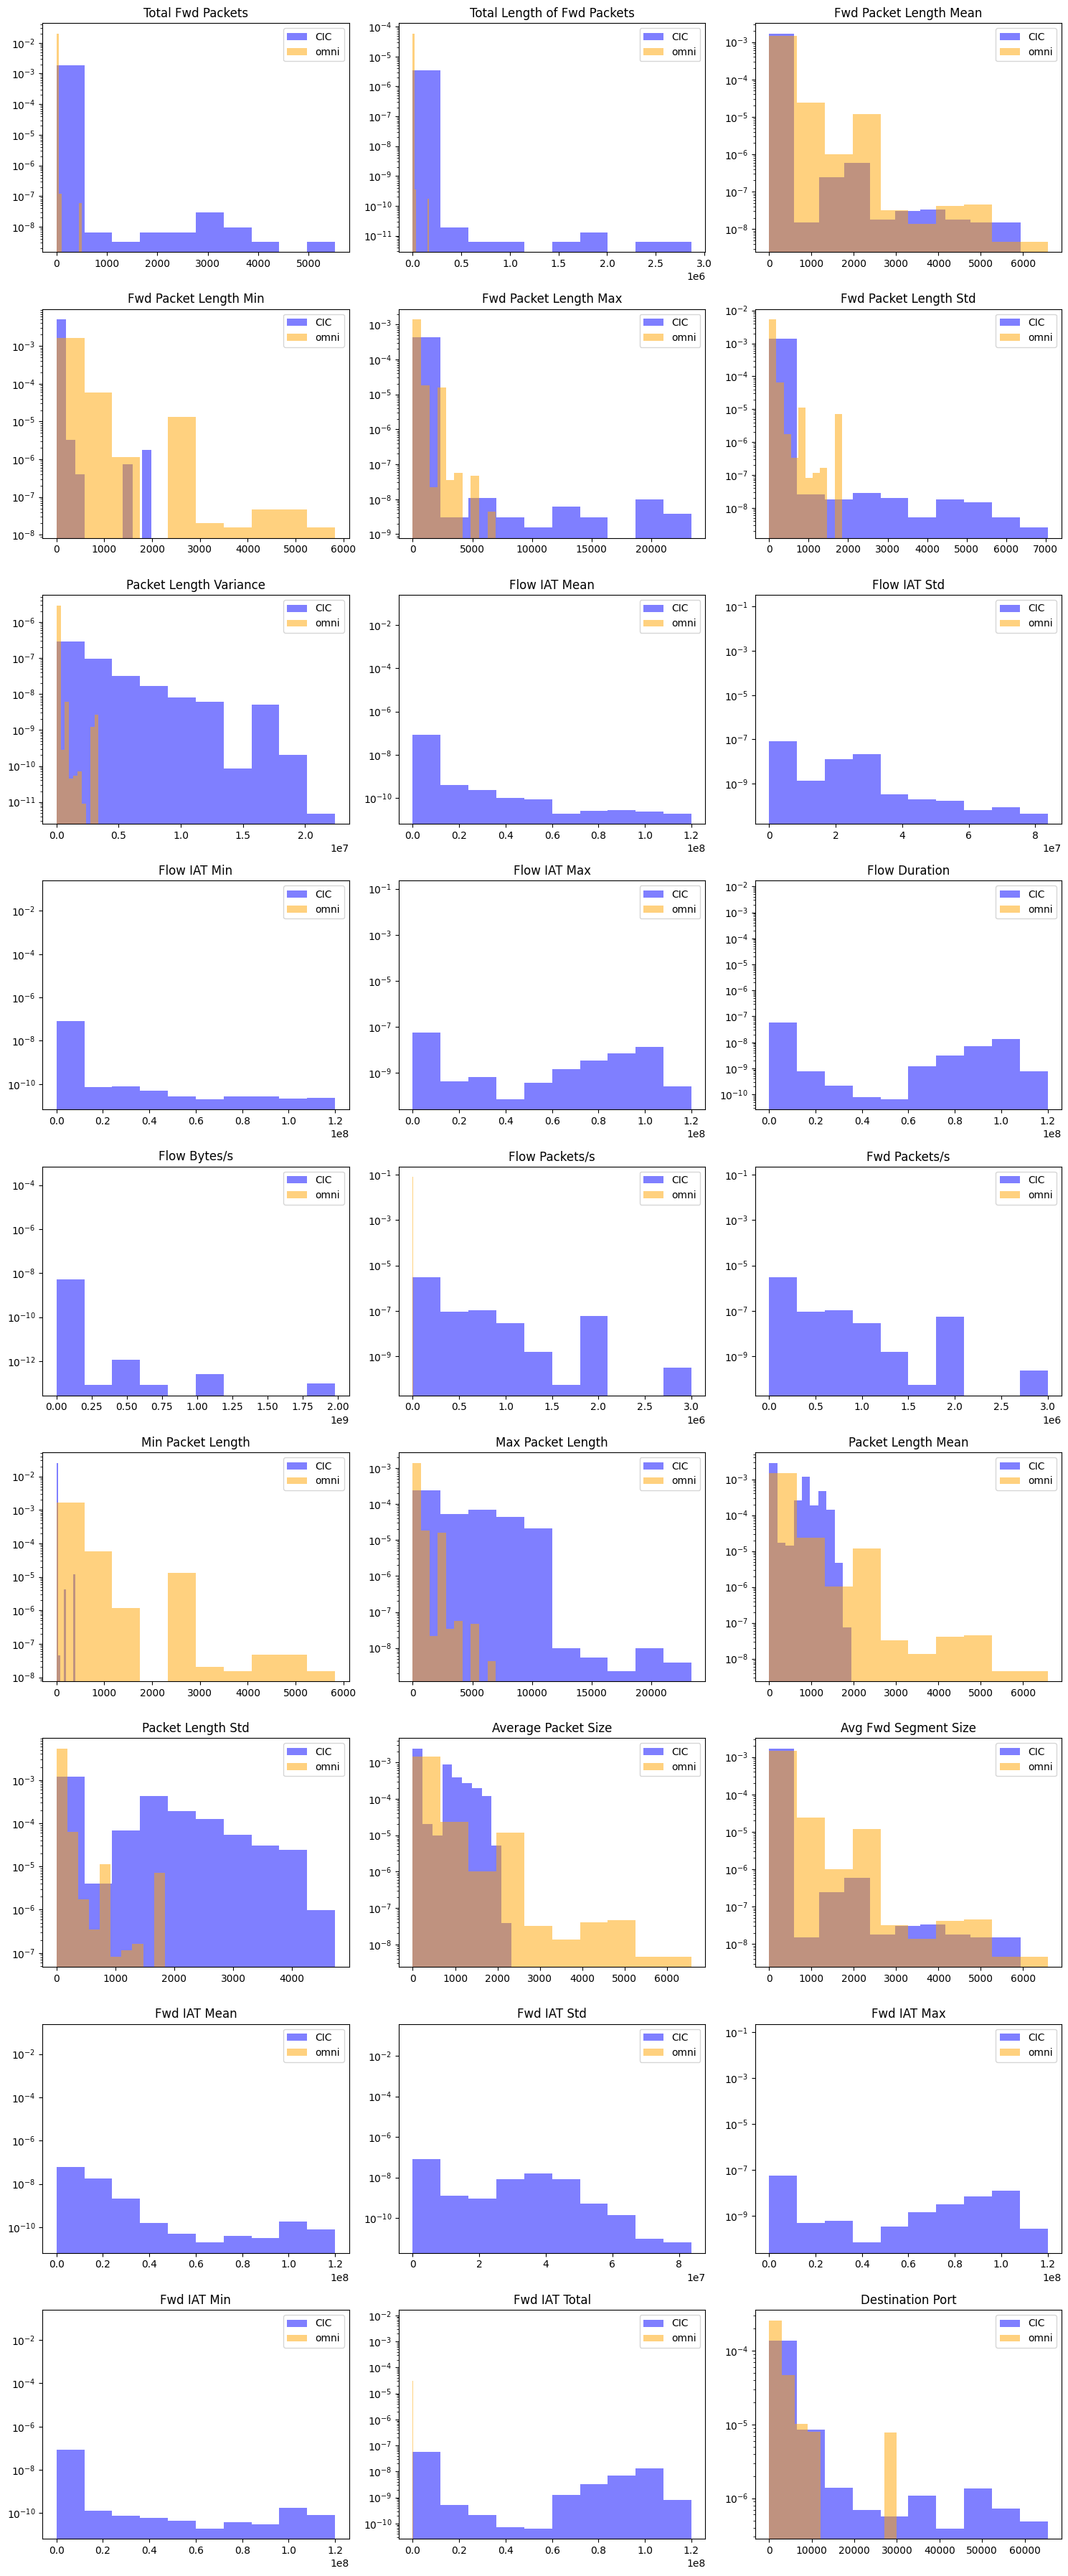

In [14]:
features = grouped_df_cic.select_dtypes(include='number').columns
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[feature], bins=10, alpha=0.5, label='CIC', color='blue', density=True)
    plt.hist(grouped_df_cic[feature], bins=10, alpha=0.5, label='omni', color='orange', density=True)
    plt.title(feature)
    plt.legend()
    plt.yscale('log')


plt.tight_layout()
plt.show()

In [15]:
df.describe()

Total Fwd Packets  Total Length of Fwd Packets  Fwd Packet Length Mean  \
count      556556.000000                 5.565560e+05           556556.000000   
mean            4.094876                 1.981773e+02               24.848931   
std            18.475176                 6.778826e+03               65.914081   
min             1.000000                 0.000000e+00                0.000000   
25%             1.000000                 0.000000e+00                0.000000   
50%             3.000000                 2.600000e+01                6.000000   
75%             6.000000                 3.260000e+02               44.142857   
max          5523.000000                 2.866110e+06             5940.857143   

       Fwd Packet Length Min  Fwd Packet Length Max  Fwd Packet Length Std  \
count          556556.000000          556556.000000          556556.000000   
mean                2.087483             114.942177              45.984842   
std                42.092699             217.935178              75.824392   
min                 0.000000               0.000000               0.000000   
25%                 0.000000               0.000000               0.000000   
50%                 0.000000               6.000000               0.000000   
75%                 0.000000             317.000000             119.616749   
max              1983.000000           23360.000000            7049.469004   

       Packet Length Variance  Flow IAT Mean  Flow IAT Std  Flow IAT Min  ...  \
count            5.565560e+05   5.565560e+05  5.565560e+05  5.565560e+05  ...   
mean             1.999662e+06   2.892205e+06  8.405503e+06  2.233378e+05  ...   
std              3.095643e+06   5.563720e+06  1.229449e+07  3.838665e+06  ...   
min              0.000000e+00   5.000000e-01  0.000000e+00 -1.300000e+01  ...   
25%              5.333333e+00   4.900000e+01  0.000000e+00  2.000000e+00  ...   
50%              1.200000e+01   4.659430e+04  7.881581e+04  5.000000e+00  ...   
75%              2.944130e+06   6.578468e+06  2.290000e+07  4.800000e+01  ...   
max              2.240000e+07   1.200000e+08  8.370000e+07  1.200000e+08  ...   

       Packet Length Mean  Packet Length Std  Average Packet Size  \
count       556556.000000      556556.000000        556556.000000   
mean           428.162249         896.571556           469.640378   
std            500.323074        1093.596586           553.210811   
min              0.000000           0.000000             0.000000   
25%              2.000000           2.309401             3.000000   
50%              6.000000           3.464102             7.500000   
75%            854.857143        1715.846853           920.615385   
max           1936.833333        4731.522394          2324.200000   

       Avg Fwd Segment Size  Fwd IAT Mean   Fwd IAT Std   Fwd IAT Max  \
count         556556.000000  5.565560e+05  5.565560e+05  5.565560e+05   
mean              24.848931  5.514674e+06  1.151668e+07  2.834528e+07   
std               65.914081  9.928093e+06  1.729540e+07  4.156235e+07   
min                0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
25%                0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
50%                6.000000  4.013500e+03  1.989798e+03  8.002000e+03   
75%               44.142857  1.190000e+07  3.020000e+07  8.350000e+07   
max             5940.857143  1.200000e+08  8.370000e+07  1.200000e+08   

        Fwd IAT Min  Fwd IAT Total  Destination Port  
count  5.565560e+05   5.565560e+05     556556.000000  
mean   5.415419e+05   2.914620e+07       2578.858081  
std    6.737672e+06   4.233110e+07       8281.191787  
min   -1.200000e+01   0.000000e+00          0.000000  
25%    0.000000e+00   0.000000e+00         80.000000  
50%    1.000000e+00   8.350000e+03         80.000000  
75%    1.800000e+01   8.410000e+07        902.000000  
max    1.200000e+08   1.200000e+08      65389.000000  

[8 rows x 27 columns]

In [16]:
grouped_df_cic.describe()

Total Fwd Packets  Total Length of Fwd Packets  Fwd Packet Length Mean  \
count      331740.000000                331740.000000           331740.000000   
mean            1.614939                   204.087786              110.856508   
std             2.045106                   702.688724              270.082935   
min             1.000000                     0.000000                0.000000   
25%             1.000000                     0.000000                0.000000   
50%             1.000000                    22.000000               22.000000   
75%             1.000000                   180.000000               87.500000   
max           500.000000                169668.000000             6578.333333   

       Fwd Packet Length Min  Fwd Packet Length Max  Fwd Packet Length Std  \
count          331740.000000           331740.00000          331740.000000   
mean               98.423940              128.31582              14.995042   
std               265.021745              305.06561              83.708384   
min                 0.000000                0.00000               0.000000   
25%                 0.000000                0.00000               0.000000   
50%                15.000000               22.00000               0.000000   
75%                57.000000              147.00000               0.000000   
max              5825.000000             6958.00000            1840.598951   

       Packet Length Variance  Flow IAT Mean   Flow IAT Std   Flow IAT Min  \
count            3.317400e+05  331740.000000  331740.000000  331740.000000   
mean             7.231924e+03       1.471930       1.147177       0.618713   
std              1.176810e+05       7.639938       6.555068       4.594769   
min              0.000000e+00       0.000000       0.000000       0.000000   
25%              0.000000e+00       0.000000       0.000000       0.000000   
50%              0.000000e+00       0.000000       0.000000       0.000000   
75%              0.000000e+00       0.000000       0.000000       0.000000   
max              3.387804e+06     120.000000      84.145707     120.000000   

       ...  Packet Length Mean  Packet Length Std  Average Packet Size  \
count  ...       331740.000000      331740.000000        331740.000000   
mean   ...          110.856508          14.995042           110.856508   
std    ...          270.082935          83.708384           270.082935   
min    ...            0.000000           0.000000             0.000000   
25%    ...            0.000000           0.000000             0.000000   
50%    ...           22.000000           0.000000            22.000000   
75%    ...           87.500000           0.000000            87.500000   
max    ...         6578.333333        1840.598951          6578.333333   

       Avg Fwd Segment Size   Fwd IAT Mean    Fwd IAT Std    Fwd IAT Max  \
count         331740.000000  331740.000000  331740.000000  331740.000000   
mean             110.856508       1.471930       1.147177       2.565078   
std              270.082935       7.639938       6.555068      12.900305   
min                0.000000       0.000000       0.000000       0.000000   
25%                0.000000       0.000000       0.000000       0.000000   
50%               22.000000       0.000000       0.000000       0.000000   
75%               87.500000       0.000000       0.000000       0.000000   
max             6578.333333     120.000000      84.145707     120.000000   

         Fwd IAT Min  Fwd IAT Total  Destination Port  
count  331740.000000  331740.000000     331740.000000  
mean        0.618713       5.021185       1875.703201  
std         4.594769      32.076577       4690.644578  
min         0.000000       0.000000         21.000000  
25%         0.000000       0.000000         23.000000  
50%         0.000000       0.000000         80.000000  
75%         0.000000       0.000000        587.000000  
max       120.000000    1508.000000      30005.000000  

[8 rows x 27 c

encode the label to make the correlation graph

In [17]:
le = LabelEncoder()

df['label_group_encoded'] = le.fit_transform(df['label_group'])
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")
print("\nUnique encoded values:", df['label_group_encoded'].unique())
print("Original labels:", df['label_group'].unique())
df.drop(columns=["label_group"], inplace=True)

BruteForce: 0
DoS/DDoS: 1
Other: 2
Scan: 3
WebAttack: 4

Unique encoded values: [1 3 2 4 0]
Original labels: ['DoS/DDoS' 'Scan' 'Other' 'WebAttack' 'BruteForce']


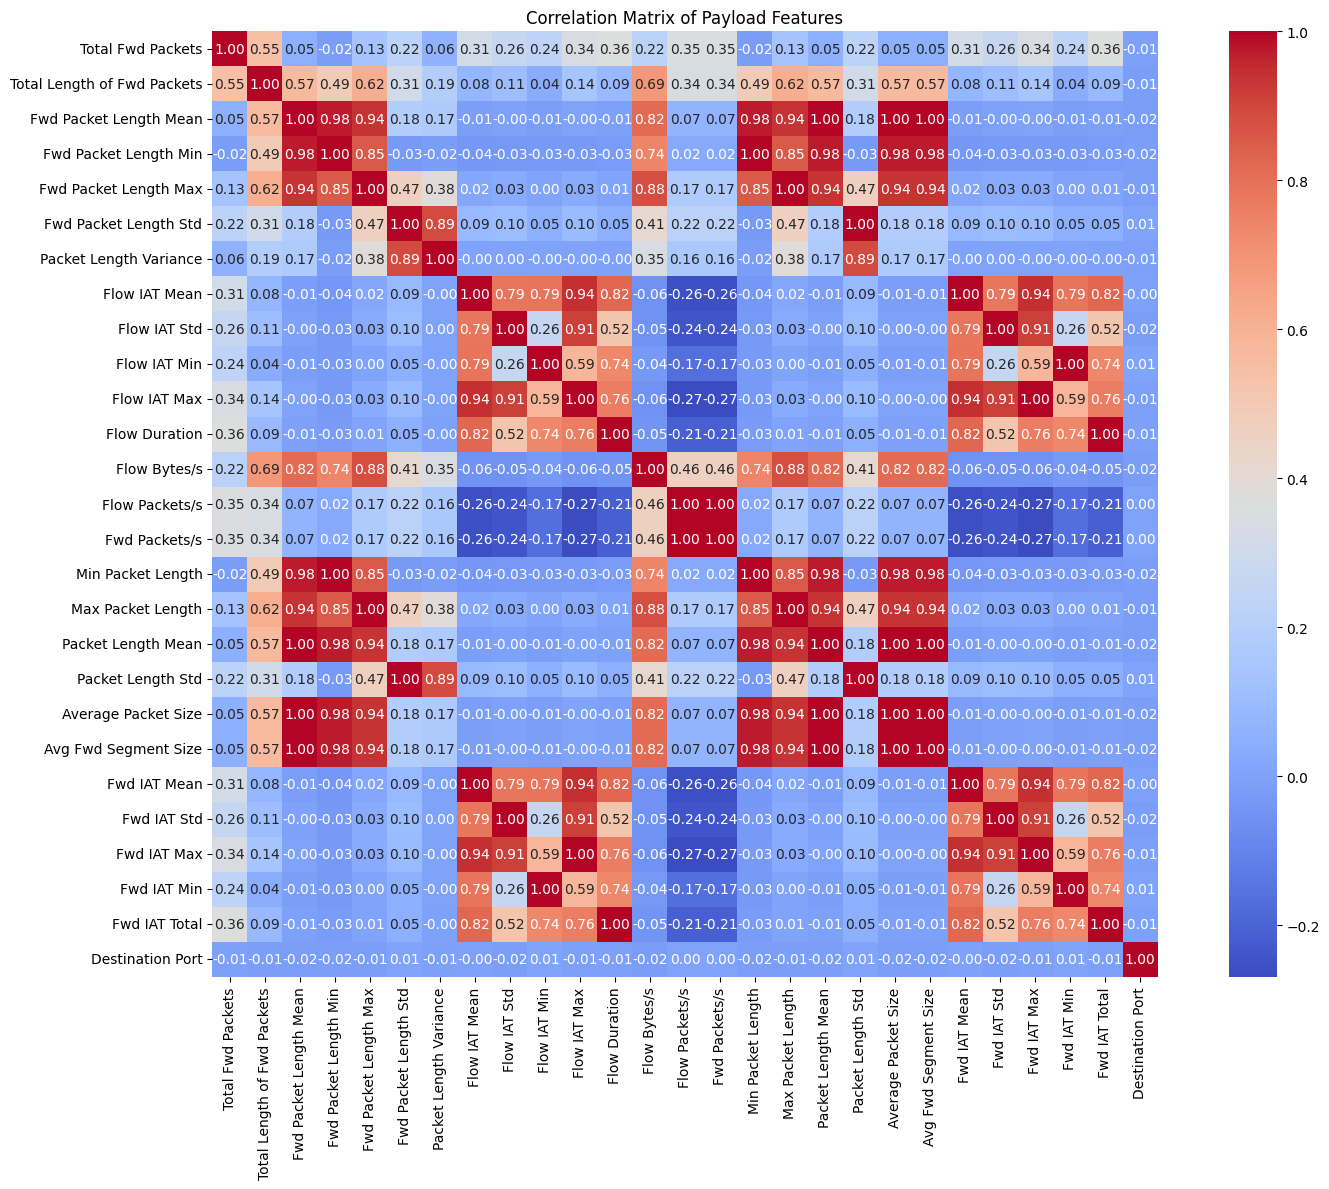

In [18]:
corr_matrix = grouped_df_cic.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Payload Features')
plt.tight_layout()

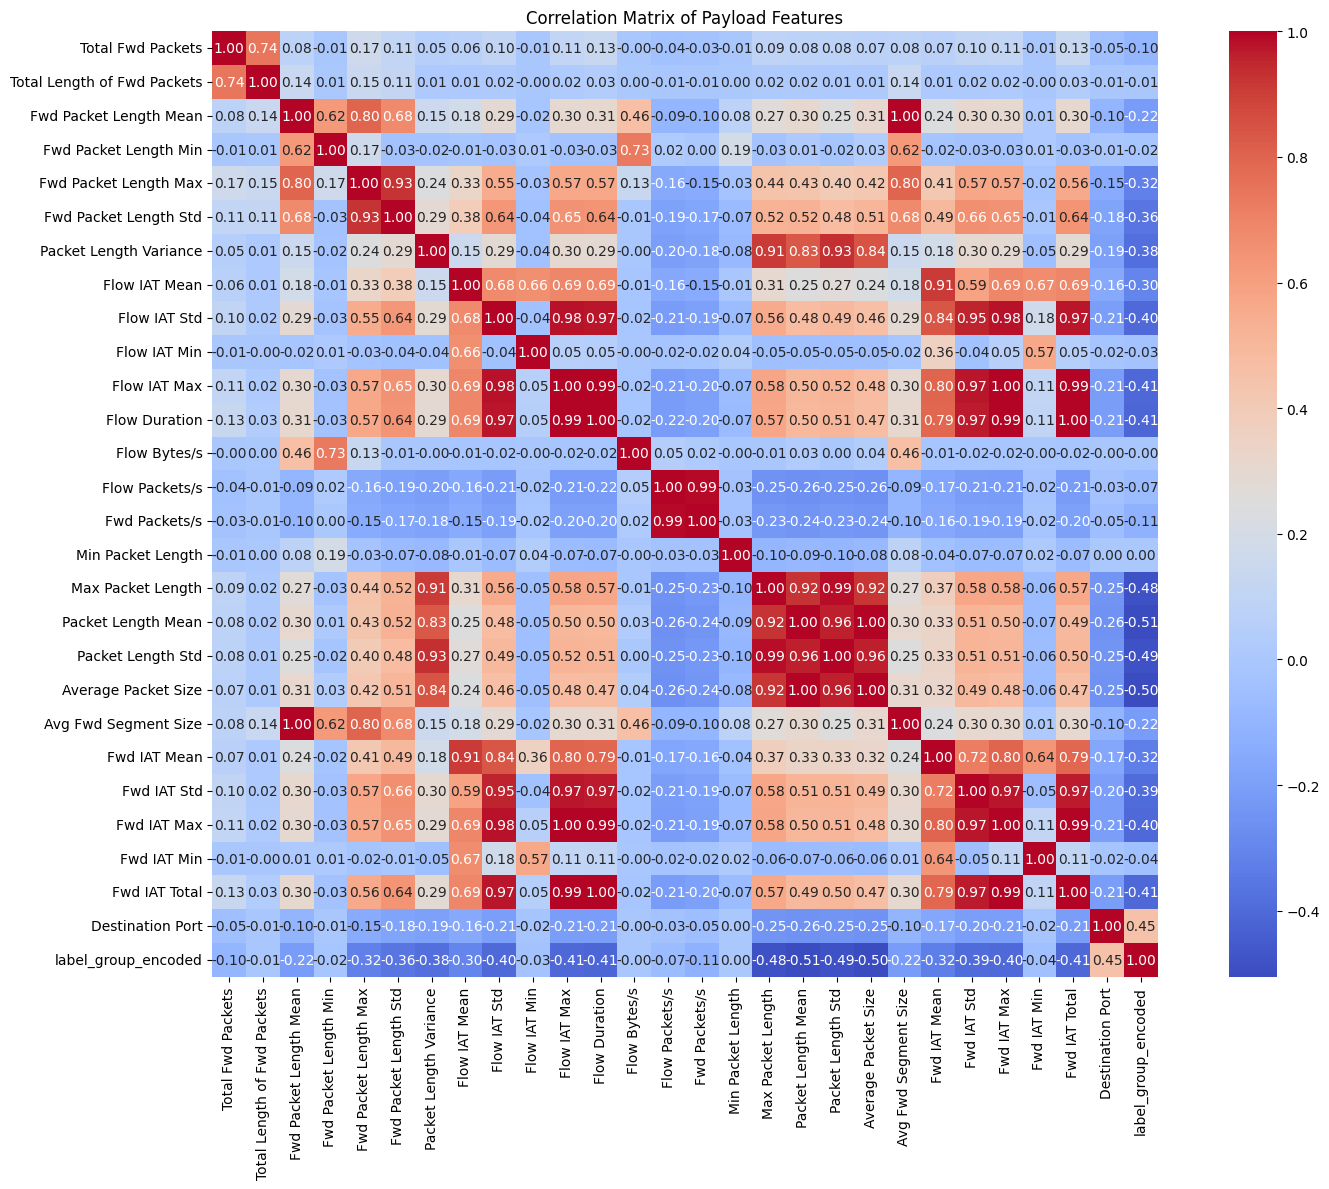

In [19]:
corr_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Payload Features')
plt.tight_layout()

# prepare the data 
- x_train x_test ect
- the omni dataset to make predictions on

In [20]:
x = df.drop(columns=["label_group_encoded"])
y = df["label_group_encoded"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
x_grouped = grouped_df_cic.copy()

scaler = QuantileTransformer()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
x_grouped = pd.DataFrame(scaler.transform(x_grouped), columns=x.columns)

# random forest model

In [21]:
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced")
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2733
           1       1.00      1.00      1.00     75865
           2       1.00      1.00      1.00       409
           3       1.00      1.00      1.00     31865
           4       0.97      0.97      0.97       440

    accuracy                           1.00    111312
   macro avg       0.99      0.99      0.99    111312
weighted avg       1.00      1.00      1.00    111312



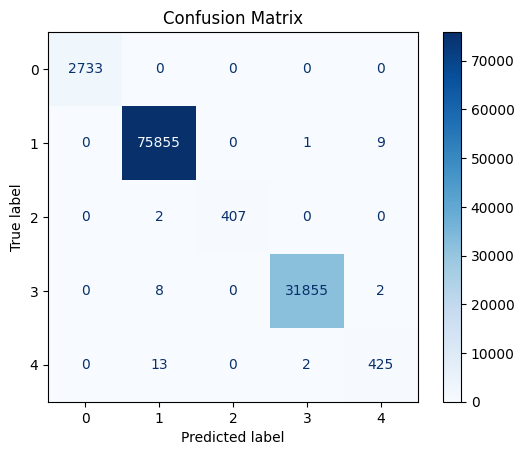

In [22]:
pred = rf.predict(x_test)
omni_pred = rf.predict(x_grouped)

print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [23]:
pd.Series(omni_pred).value_counts()

1    164836
0    134279
4     29357
2      2632
3       636
Name: count, dtype: int64

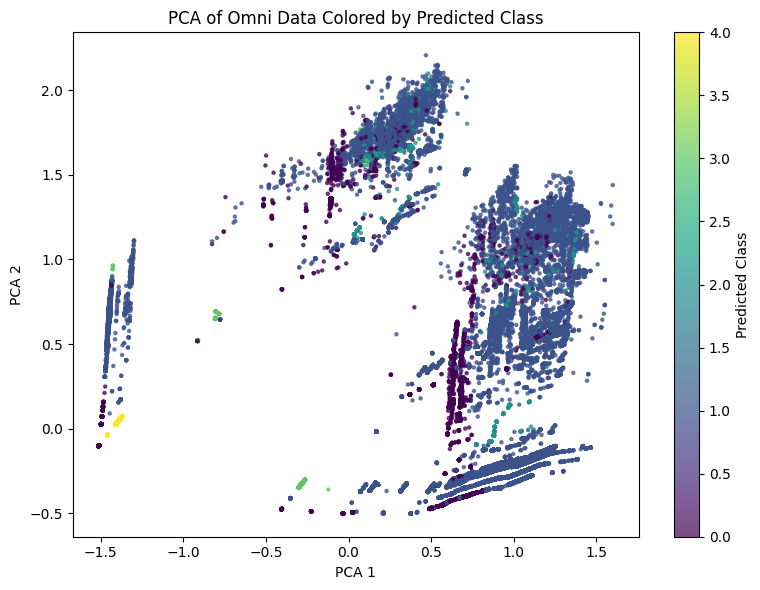

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_grouped)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

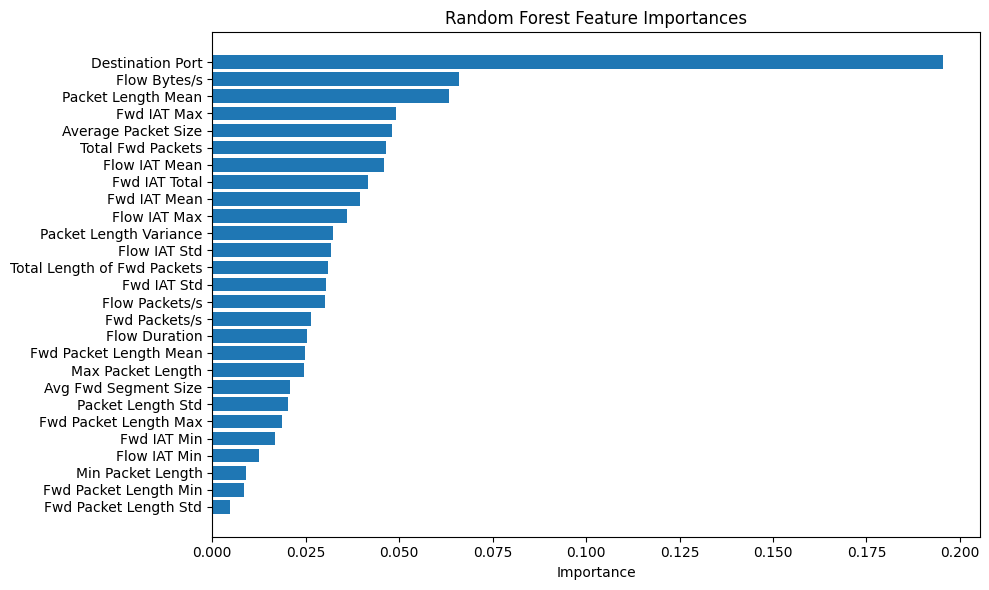

In [25]:
importances = rf.feature_importances_
feature_names = x.columns

# Create a DataFrame for better visualization
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# neural network

In [26]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Add
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout


In [27]:
class F1ScoreCallback(Callback):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred_probs = self.model.predict(self.x_val)
        y_pred = np.argmax(y_pred_probs, axis=1)
        f1 = f1_score(self.y_val, y_pred, average='macro')  # or 'weighted'
        print(f"\nEpoch {epoch+1}: F1 Score = {f1:.4f}")


inp = Input(shape=(x_train.shape[1],))
x1 = Dense(512)(inp)
x1 = BatchNormalization()(x1)
x1 = tf.keras.activations.relu(x1)
x1 = Dropout(0.2)(x1)

x2 = Dense(256)(x1)
x2 = BatchNormalization()(x2)
x2 = tf.keras.activations.relu(x2)
x2 = Dropout(0.2)(x2)

x3 = Dense(128)(x2)
x3 = BatchNormalization()(x3)
x3 = tf.keras.activations.relu(x3)
x3 = Dropout(0.2)(x3)

x4 = Dense(64)(x3)
x4 = BatchNormalization()(x4)
x4 = tf.keras.activations.relu(x4)

output = Dense(5, activation='softmax')(x4)

model = Model(inputs=inp, outputs=output)


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,981 (746.02 KB)

 Trainable params: 189,061 (738.52 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [28]:
f1_callback = F1ScoreCallback(x_val=x_test, y_val=y_test)
cp = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="loss",
    mode="min"
)

model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[f1_callback])

Epoch 1/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 4s 994us/step

Epoch 1: F1 Score = 0.9742
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - accuracy: 0.9920 - loss: 0.0312 - val_accuracy: 0.9985 - val_loss: 0.0063
Epoch 2/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 896us/step

Epoch 2: F1 Score = 0.9891
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.9976 - loss: 0.0084 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 3/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 906us/step

Epoch 3: F1 Score = 0.9928
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 4/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 912us/step

Epoch 4: F1 Score = 0.9932
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9987 - loss: 0.0050 - val_accuracy: 0.9993 - val_loss: 0.0034
Epoch 5/20
3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 900us/step

Epoch 5: F1 Score = 0.9954
13914/13914 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9989 - loss: 0.0044 - val_accura

In [29]:
pred_probs = model.predict(x_test)
pred = pred_probs.argmax(axis=1)

omni_probs = model.predict(x_grouped)
omni_pred = omni_probs.argmax(axis=1)
pred_save = omni_pred.copy()

3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 884us/step
10367/10367 ━━━━━━━━━━━━━━━━━━━━ 10s 922us/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2733
           1       1.00      1.00      1.00     75865
           2       1.00      1.00      1.00       409
           3       1.00      1.00      1.00     31865
           4       0.99      0.96      0.98       440

    accuracy                           1.00    111312
   macro avg       1.00      0.99      0.99    111312
weighted avg       1.00      1.00      1.00    111312



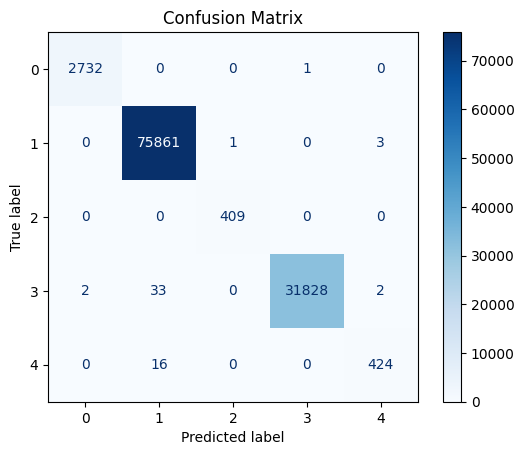

In [30]:
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [31]:
pd.Series(omni_pred).value_counts()

1    115207
2     95967
0     88540
4     28308
3      3718
Name: count, dtype: int64

## PCA

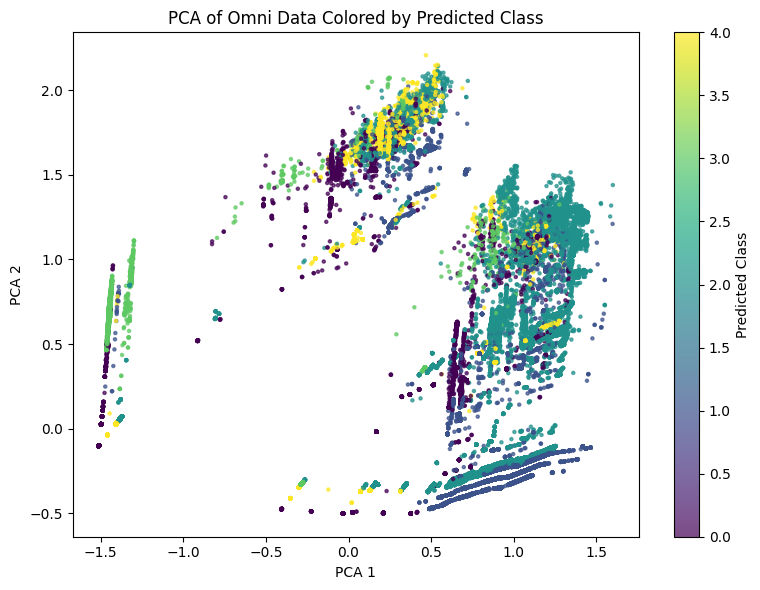

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

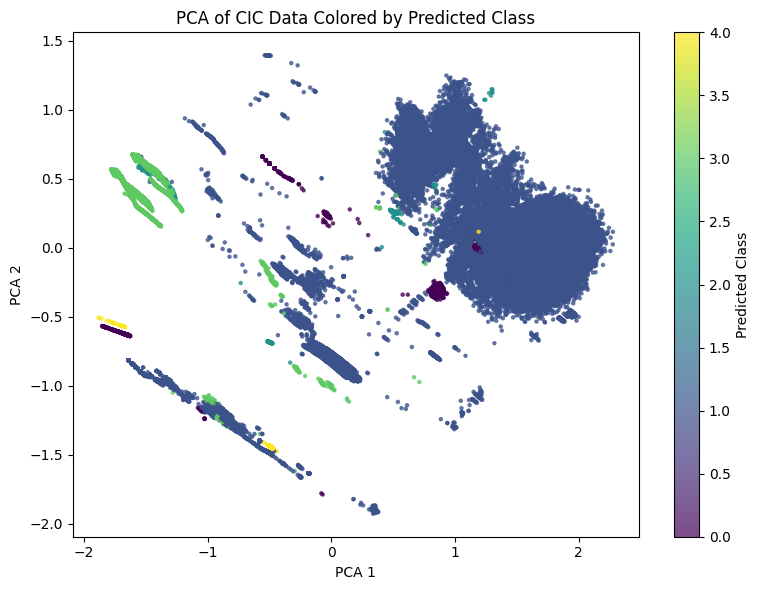

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of CIC Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

## umap

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

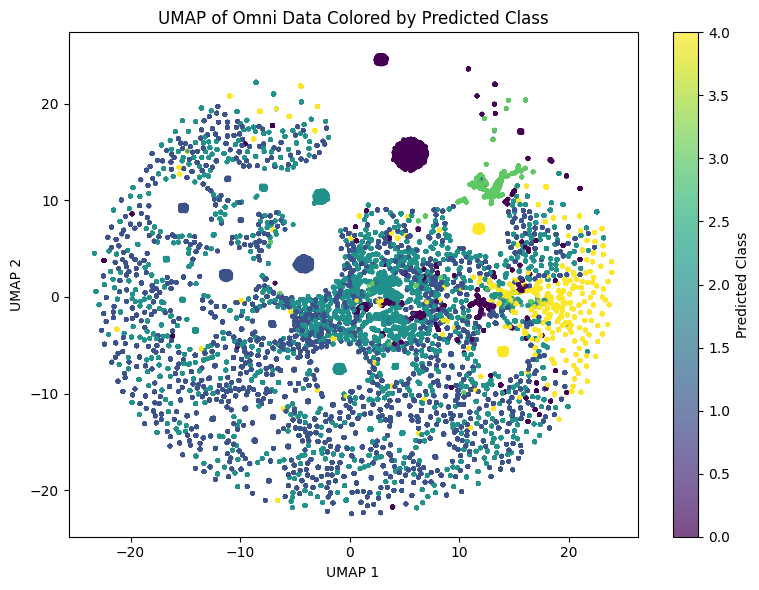

In [34]:
import umap
pca = umap.UMAP()
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

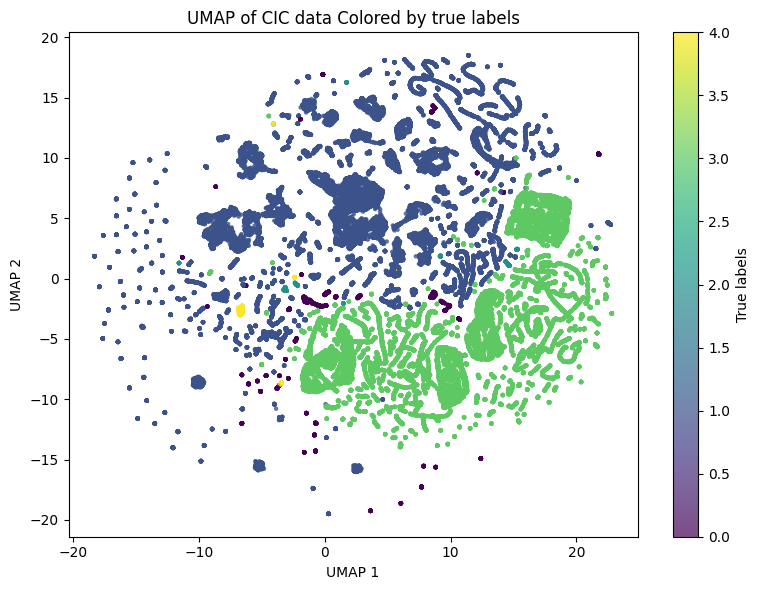

In [35]:
pca = umap.UMAP()
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of CIC data Colored by true labels')
plt.colorbar(scatter, label='True labels')
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 201it [00:51,  3.39it/s]                         
C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_17140\1368093946.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test[:200], feature_names=feature_names)


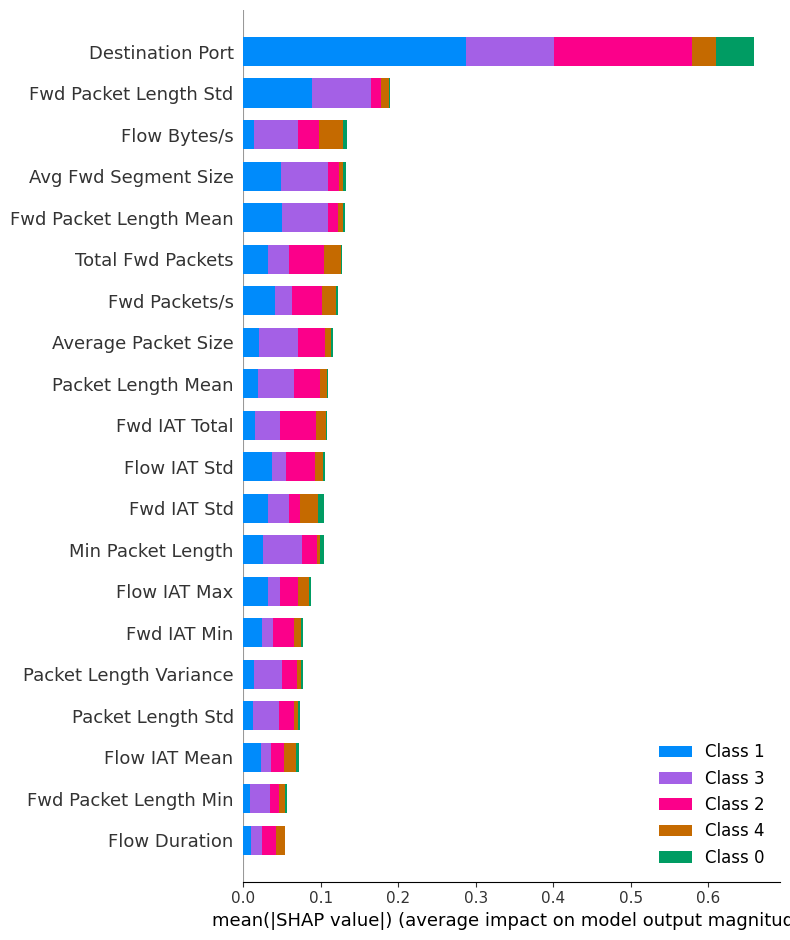

In [36]:
import shap

background = x_train.iloc[np.random.choice(x_train.shape[0], 100, replace=False)]

explainer = shap.Explainer(model, background)
shap_values = explainer(x_test[:200])

shap.summary_plot(shap_values, x_test[:200], feature_names=feature_names)

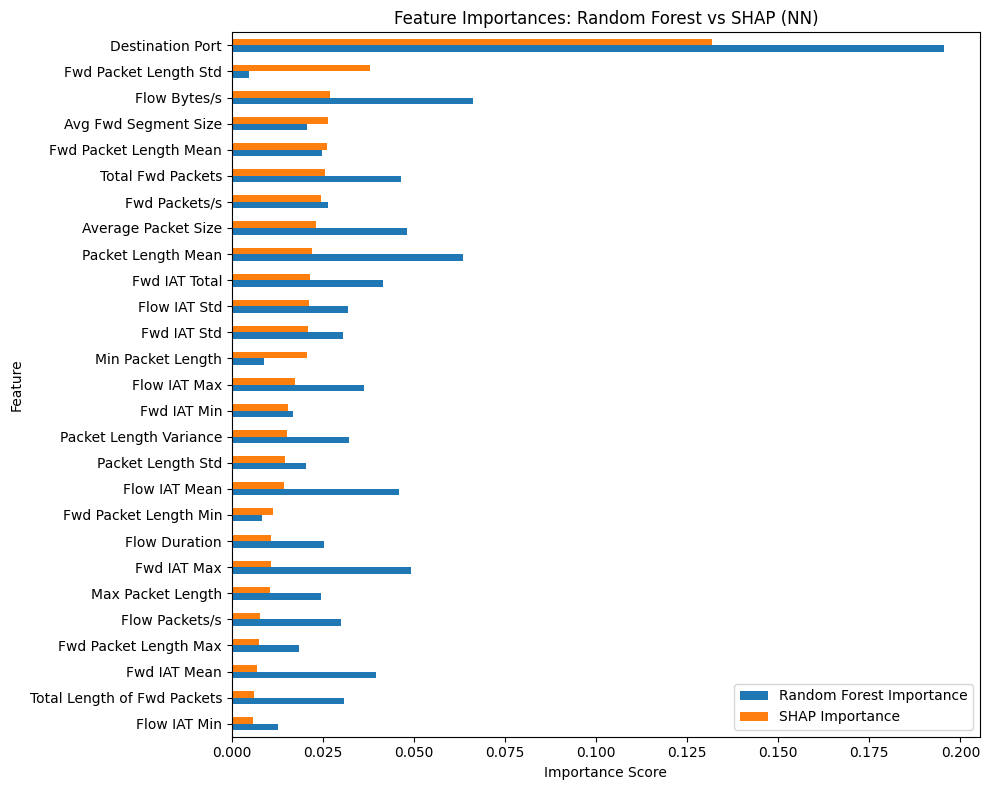

In [37]:
rf_importances = np.array(rf.feature_importances_).flatten()
shap_vals = shap_values.values  
shap_importance = np.abs(shap_vals).mean(axis=0).mean(axis=1)

assert len(rf_importances) == len(shap_importance) == x_train.shape[1]

# Create the comparison DataFrame
compare_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Random Forest Importance': rf_importances,
    'SHAP Importance': shap_importance
}).set_index('Feature')

# Sort and plot
compare_df = compare_df.sort_values('SHAP Importance', ascending=True)

compare_df.plot(kind='barh', figsize=(10, 8))
plt.title('Feature Importances: Random Forest vs SHAP (NN)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


## destination port to predicted label graphs
with this model and the random forest seeing the importance of teh destination port I was scared that the model predicted the same value based on the destination port

These graphs shows that that isn't exactly true even though it does tend to lean towards a class based on the destination port.

### true value graph of ports vs label
given the model is almost perfect we can say that the ture lable graph is also the predicted graph

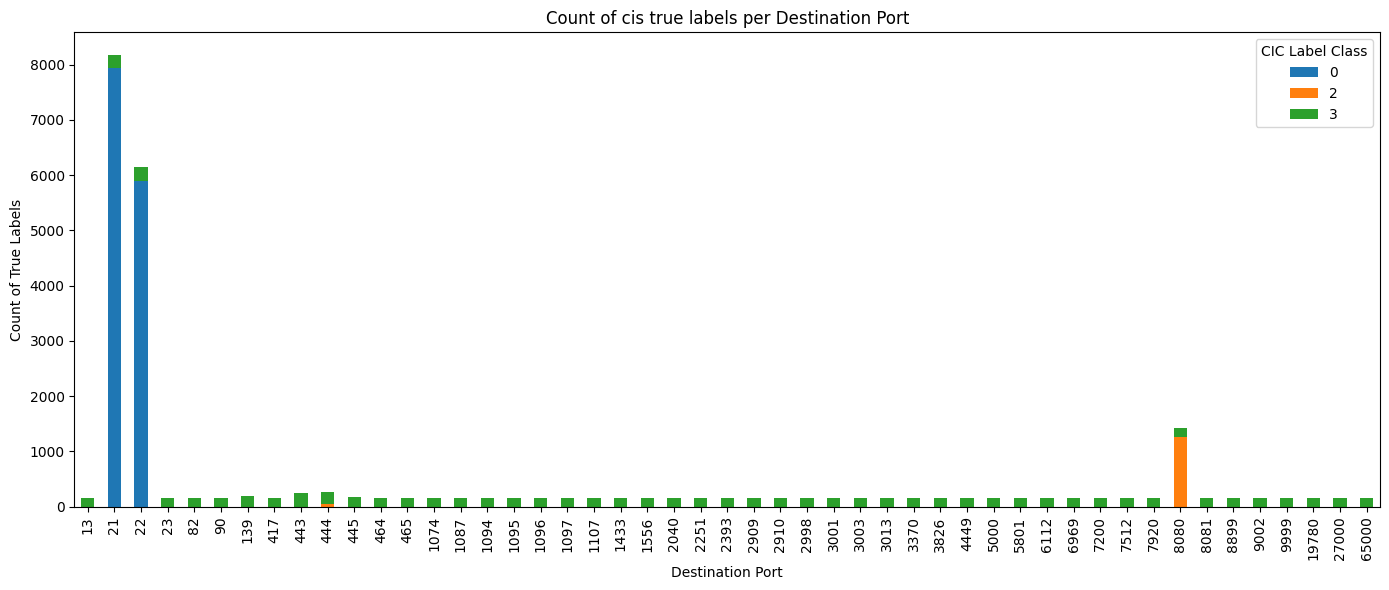

In [38]:
 # remove the first port (80) as it had 40000 thousand entries and it was dominating the plot, class 1 and 4 where in the port 80
top_ports = df['Destination Port'].value_counts().head(50)[1:].index
df_top = df[df['Destination Port'].isin(top_ports)].copy()
count_df = df_top.groupby(['Destination Port', 'label_group_encoded']).size().unstack(fill_value=0)

count_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.xlabel('Destination Port')
plt.ylabel('Count of True Labels')
plt.title('Count of cis true labels per Destination Port')
plt.legend(title='CIC Label Class')
plt.tight_layout()
plt.show()

### graph of predicted label vs destination port for both cic datset and omni dataset

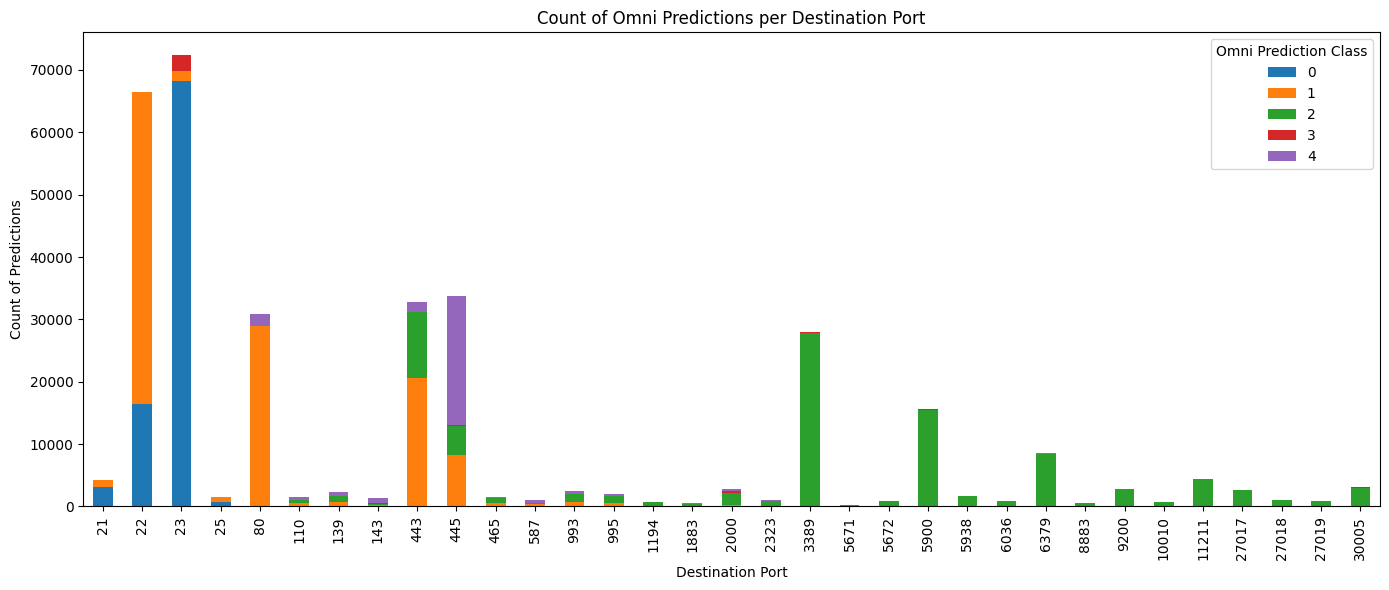

In [39]:
temp = grouped_df.copy()
temp['omni_pred'] = omni_pred

count_df = temp.groupby(['cic_Destination Port', 'omni_pred']).size().unstack(fill_value=0)

count_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.xlabel('Destination Port')
plt.ylabel('Count of Predictions')
plt.title('Count of Omni Predictions per Destination Port')
plt.legend(title='Omni Prediction Class')
plt.tight_layout()
plt.show()

# Analysis of the predictions based on the commands that were extracted in the omni payload

check if the predicted scan or ddos or other have commands that are expected of such attacks

In [40]:
df_analysis = grouped_df.copy()
df_analysis['predicted_label'] = omni_pred
cmd_cols = [col for col in df_analysis.columns if col.startswith('cmd_')]

# Get proportions per class
binary_feature_means = df_analysis.groupby('predicted_label')[cmd_cols].mean() *100

label_map = {
    0: 'BruteForce',
    1: 'DoS/DDoS',
    2: 'Other',
    3: 'Scan',
    4: 'WebAttack'
}

binary_feature_means = binary_feature_means.rename(index=label_map)

print(binary_feature_means.round(2))

                 cmd_wget_max  cmd_curl_max  cmd_chmod_max  cmd_dd_max  \
predicted_label                                                          
BruteForce               0.00          0.12           0.00        0.01   
DoS/DDoS                 0.30          0.45           0.23        1.04   
Other                    0.00          0.62           0.00        2.13   
Scan                     0.00          0.03           0.00        0.00   
WebAttack                0.02          0.01           0.02        0.04   

                 cmd_http_over_ssh_max  cmd_scp_max  cmd_ftp_max  cmd_nc_max  \
predicted_label                                                                
BruteForce                        1.05         0.03         1.09        0.25   
DoS/DDoS                          0.75         0.30         0.93        2.27   
Other                             0.00         0.49         0.00        6.07   
Scan                              0.03         0.03         0.00        0.91   
W

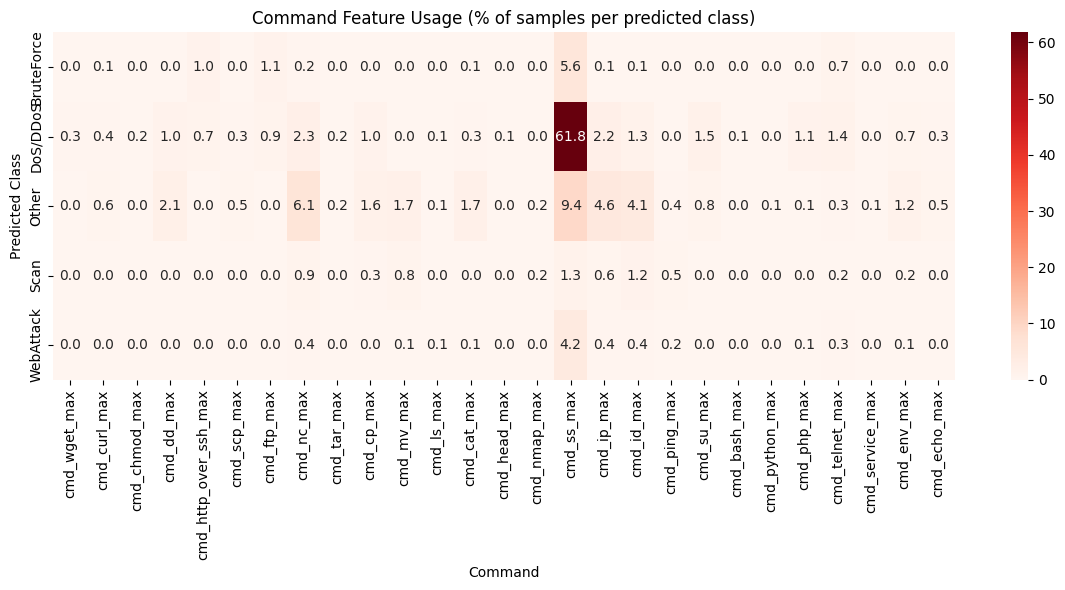

In [41]:
plt.figure(figsize=(12, 6))
sns.heatmap(binary_feature_means, annot=True, cmap="Reds", fmt=".1f")
plt.title("Command Feature Usage (% of samples per predicted class)")
plt.xlabel("Command")
plt.ylabel("Predicted Class")
plt.tight_layout()
plt.show()

# Model with high confidence predictions

combined the data from the previous model and the very high confidence predictions of the moni data (>0.97) to then retrain and see if there is an improvement in the performance

In [42]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [43]:
confidence_threshold = 0.95

high_conf_samples = []
high_conf_labels = []

for class_idx in range(omni_probs.shape[1]):
    class_mask = (omni_pred == class_idx) & (omni_probs[:, class_idx] >= confidence_threshold)
    selected = x_grouped[class_mask]
    high_conf_samples.append(selected)
    high_conf_labels.extend([class_idx] * selected.shape[0])

if high_conf_samples:
    x_high_conf = pd.concat(high_conf_samples, axis=0)
    y_high_conf = np.array(high_conf_labels)
else:
    x_high_conf = pd.DataFrame()
    y_high_conf = np.array([])

print(f"Selected {len(y_high_conf)} high-confidence samples.")

x_high_conf_train, x_test_aug, y_high_conf_train, y_test_aug = train_test_split(
    x_high_conf,
    y_high_conf,
    test_size=0.3,
    stratify=y_high_conf
)

x_train_aug = pd.concat([x_train, x_high_conf_train], axis=0)
y_train_aug = np.concatenate([y_train, y_high_conf_train], axis=0)

print(f"Training set size after augmentation: {len(x_train_aug)}, test set size: {len(x_test_aug)}")


Selected 280251 high-confidence samples.
Training set size after augmentation: 641419, test set size: 84076


In [44]:
# create a mask for labeled and pseudo-labeled data
n_labeled = len(x_train)
labeled_mask = np.concatenate([
    np.ones(len(x_train), dtype=bool),      # labeled
    np.zeros(len(x_high_conf_train), dtype=bool)  # pseudo-labeled
])

In [45]:
# convert to tensors
x_train_aug_tensor = tf.convert_to_tensor(x_train_aug.values, dtype=tf.float32)
y_train_aug_tensor = tf.convert_to_tensor(y_train_aug, dtype=tf.int32)
labeled_mask_tensor = tf.convert_to_tensor(labeled_mask, dtype=tf.bool)

In [46]:
# build dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((x_train_aug_tensor, labeled_mask_tensor), y_train_aug_tensor))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(32)

In [47]:
inp = Input(shape=(x_train_aug.shape[1],))
x1 = Dense(512)(inp)
x1 = BatchNormalization()(x1)
x1 = tf.keras.activations.relu(x1)
x1 = Dropout(0.2)(x1)

x2 = Dense(256)(x1)
x2 = BatchNormalization()(x2)
x2 = tf.keras.activations.relu(x2)
x2 = Dropout(0.2)(x2)

x3 = Dense(128)(x2)
x3 = BatchNormalization()(x3)
x3 = tf.keras.activations.relu(x3)
x3 = Dropout(0.2)(x3)

x4 = Dense(64)(x3)
x4 = BatchNormalization()(x4)
x4 = tf.keras.activations.relu(x4)

output = Dense(5, activation='softmax')(x4)

base_model = Model(inputs=inp, outputs=output)

In [48]:
class SelectiveConsistencyModel(tf.keras.Model):
    def __init__(self, base_model, lambda_consistency=0.5):
        super().__init__()
        self.base_model = base_model
        self.lambda_consistency = lambda_consistency

    def call(self, inputs, training=False):
        return self.base_model(inputs, training=training)

    def train_step(self, data):
        (x_batch, labeled_mask), y_batch = data

        pseudo_mask = tf.logical_not(labeled_mask)
        noise = tf.random.normal(tf.shape(x_batch), mean=0.0, stddev=0.05)
        x_aug = tf.where(tf.expand_dims(pseudo_mask, -1), x_batch + noise, x_batch)

        with tf.GradientTape() as tape:
            pred = self(x_batch, training=True)

            # Supervised loss (masked)
            labeled_mask_float = tf.cast(labeled_mask, tf.float32)
            loss_all = tf.keras.losses.sparse_categorical_crossentropy(y_batch, pred)
            loss_supervised = tf.reduce_sum(loss_all * labeled_mask_float) / (tf.reduce_sum(labeled_mask_float) + 1e-8)

            # Consistency loss (pseudo-labeled)
            pred_aug = self(x_aug, training=True)
            consistency_mask = tf.cast(pseudo_mask, tf.float32)
            consistency_weight = tf.expand_dims(consistency_mask, -1)
            loss_consistency = tf.reduce_sum(tf.square(pred - pred_aug) * consistency_weight) / (tf.reduce_sum(consistency_mask) + 1e-8)

            total_loss = loss_supervised + self.lambda_consistency * loss_consistency

        # Apply gradients
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Track metrics
        self.compiled_metrics.update_state(y_batch, pred)

        return {
            "loss": total_loss,
            **{m.name: m.result() for m in self.metrics}
        }

def test_step(self, data):
    x, y = data
    preds = self(x, training=False)
    loss = self.compute_loss(x, y, preds)
    for metric in self.metrics:
        metric.update_state(y, preds)

    return {
        "loss": loss,
        **{m.name: m.result() for m in self.metrics}
    }


model = SelectiveConsistencyModel(base_model=base_model, lambda_consistency=0.5)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
model.fit(
    train_dataset,
    epochs=20,
    validation_data=(x_test, y_test)
)

Epoch 1/20
20045/20045 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.9683 - loss: 0.2000 - val_accuracy: 0.9655 - val_loss: 0.2035
Epoch 2/20
20045/20045 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9623 - loss: 0.2000 - val_accuracy: 0.9923 - val_loss: 0.0648
Epoch 3/20
20045/20045 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9801 - loss: 0.2000 - val_accuracy: 0.9833 - val_loss: 0.0907
Epoch 4/20
20045/20045 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9791 - loss: 0.2000 - val_accuracy: 0.9751 - val_loss: 0.1252
Epoch 5/20
20045/20045 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.9873 - loss: 0.2000 - val_accuracy: 0.9834 - val_loss: 0.0562
Epoch 6/20
20045/20045 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.9779 - loss: 0.2000 - val_accuracy: 0.9530 - val_loss: 0.1259
Epoch 7/20
20045/20045 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.9782 - loss: 0.2000 - val_accuracy: 0.9822 - val_loss: 0.1239
Epoch 8/20
20045/20045 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 

In [50]:
pred_probs = model.predict(x_test)
pred = pred_probs.argmax(axis=1)

augmented = model.predict(x_test_aug)
augmented_pred = augmented.argmax(axis=1)

omni_probs = model.predict(x_grouped)
omni_pred = omni_probs.argmax(axis=1)

3479/3479 ━━━━━━━━━━━━━━━━━━━━ 3s 946us/step
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 2s 884us/step
10367/10367 ━━━━━━━━━━━━━━━━━━━━ 9s 912us/step


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2733
           1       0.99      1.00      1.00     75865
           2       1.00      0.67      0.80       409
           3       1.00      1.00      1.00     31865
           4       1.00      0.05      0.10       440

    accuracy                           0.99    111312
   macro avg       0.99      0.74      0.78    111312
weighted avg       0.99      0.99      0.99    111312



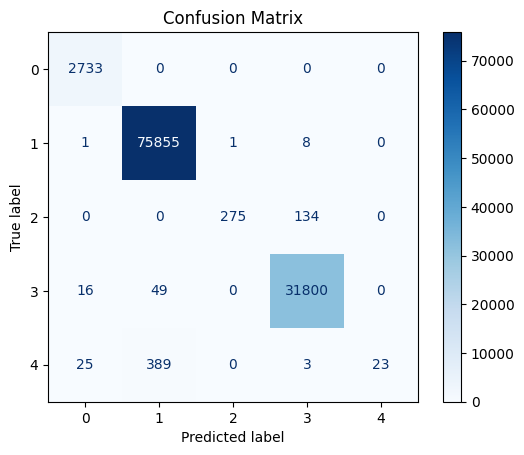

In [51]:
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.98      0.75     26492
           1       0.83      0.00      0.00     30520
           2       0.55      0.77      0.64     21989
           3       0.01      0.13      0.02       890
           4       1.00      0.00      0.00      4185

    accuracy                           0.51     84076
   macro avg       0.60      0.38      0.28     84076
weighted avg       0.69      0.51      0.40     84076



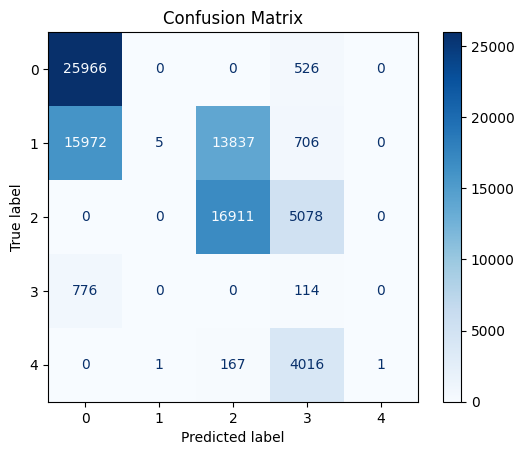

In [52]:
print(classification_report(y_test_aug, augmented_pred))

cm = confusion_matrix(y_test_aug, augmented_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Comparing previous predictions with new model predictiosn withthe augmented dataset

              precision    recall  f1-score   support

           0       0.61      0.98      0.75     88540
           1       0.89      0.00      0.00    115207
           2       0.50      0.63      0.56     95967
           3       0.01      0.20      0.02      3718
           4       1.00      0.00      0.00     28308

    accuracy                           0.45    331740
   macro avg       0.60      0.36      0.27    331740
weighted avg       0.70      0.45      0.36    331740



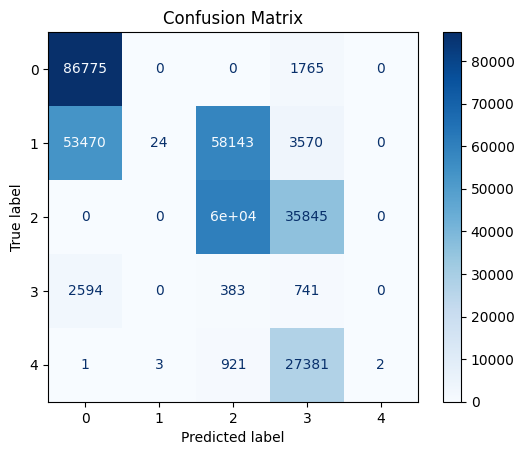

In [53]:
print(classification_report(pred_save, omni_pred))

cm = confusion_matrix(pred_save, omni_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [54]:
pd.Series(omni_pred).value_counts()

0    142840
2    119569
3     69302
1        27
4         2
Name: count, dtype: int64

## PCA aumgented

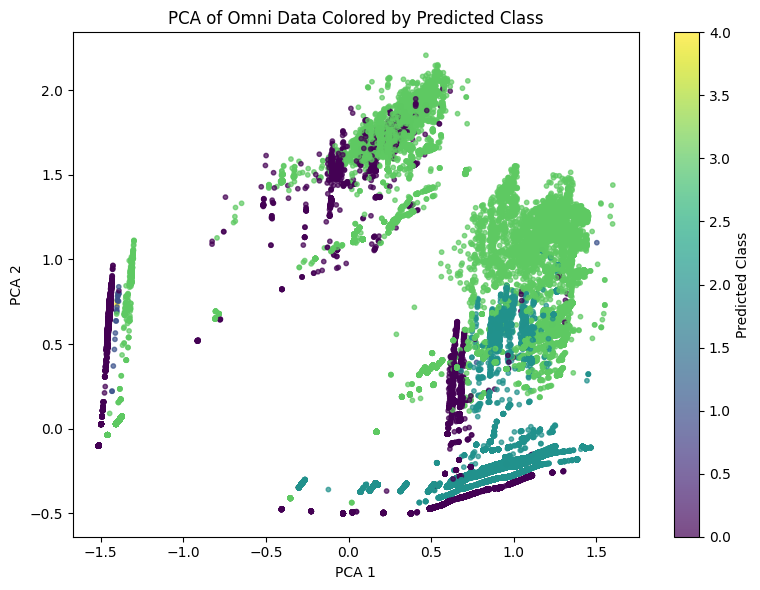

In [55]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=10)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

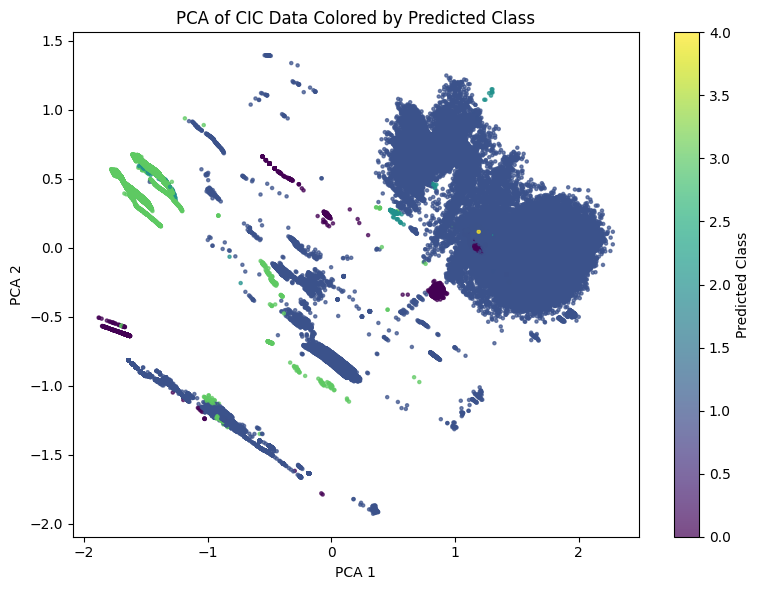

In [56]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of CIC Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

## UMAP augmented

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

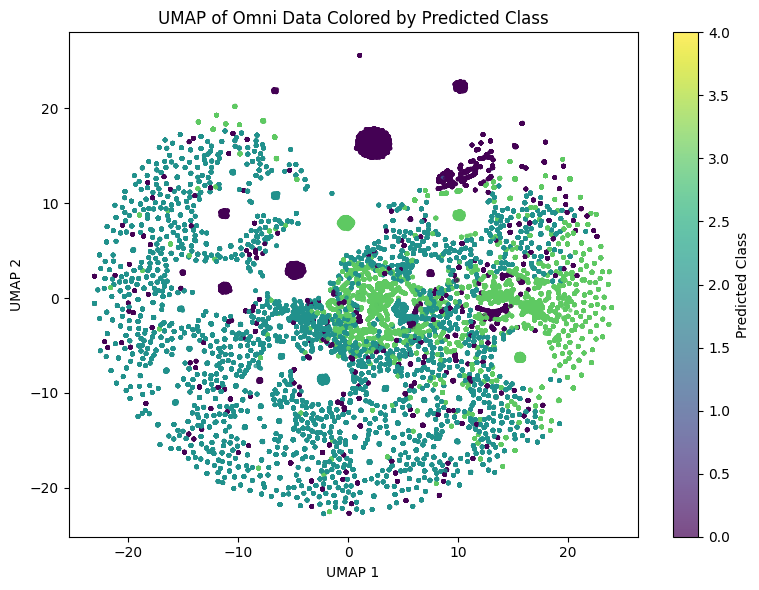

In [57]:
import umap
pca = umap.UMAP()
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

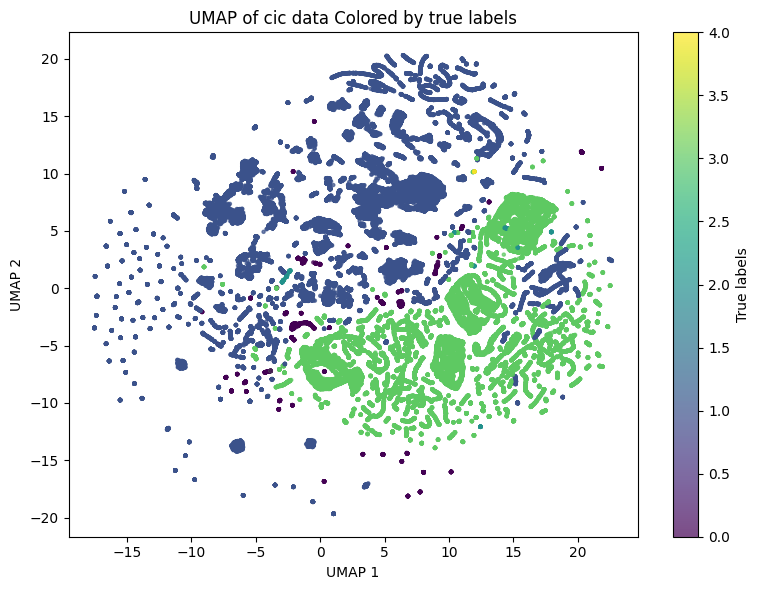

In [58]:
pca = umap.UMAP()
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of cic data Colored by true labels')
plt.colorbar(scatter, label='True labels')
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 201it [00:52,  3.09it/s]                         
C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_17140\1368093946.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test[:200], feature_names=feature_names)


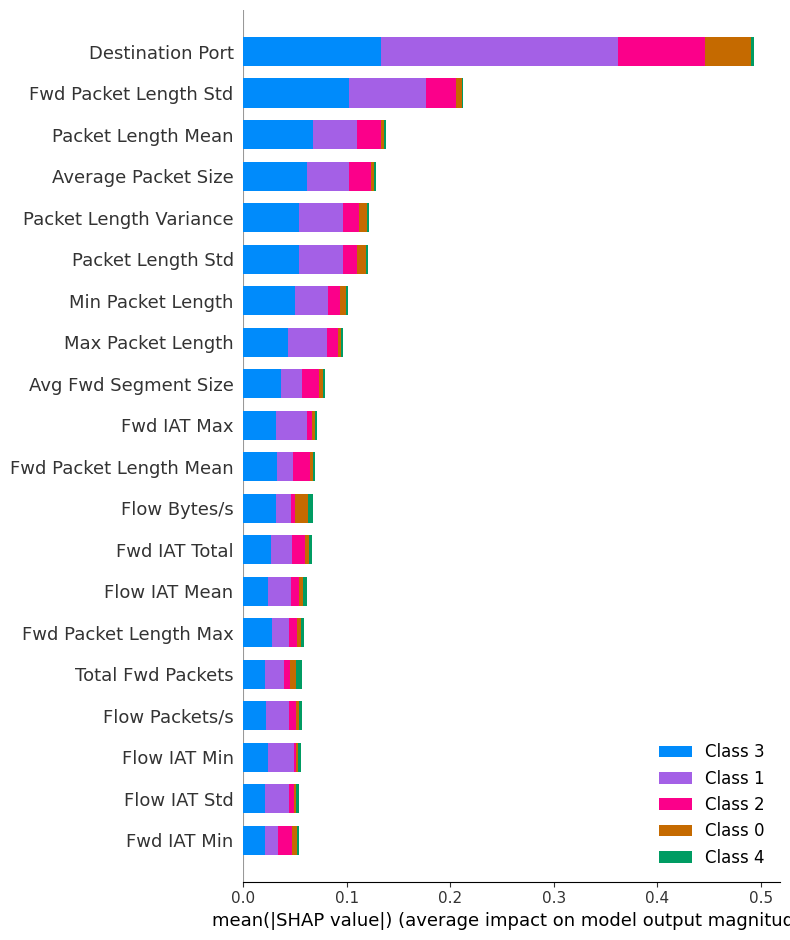

In [59]:
import shap

background = x_train.iloc[np.random.choice(x_train.shape[0], 100, replace=False)]

explainer = shap.Explainer(model, background)
shap_values = explainer(x_test[:200])

shap.summary_plot(shap_values, x_test[:200], feature_names=feature_names)

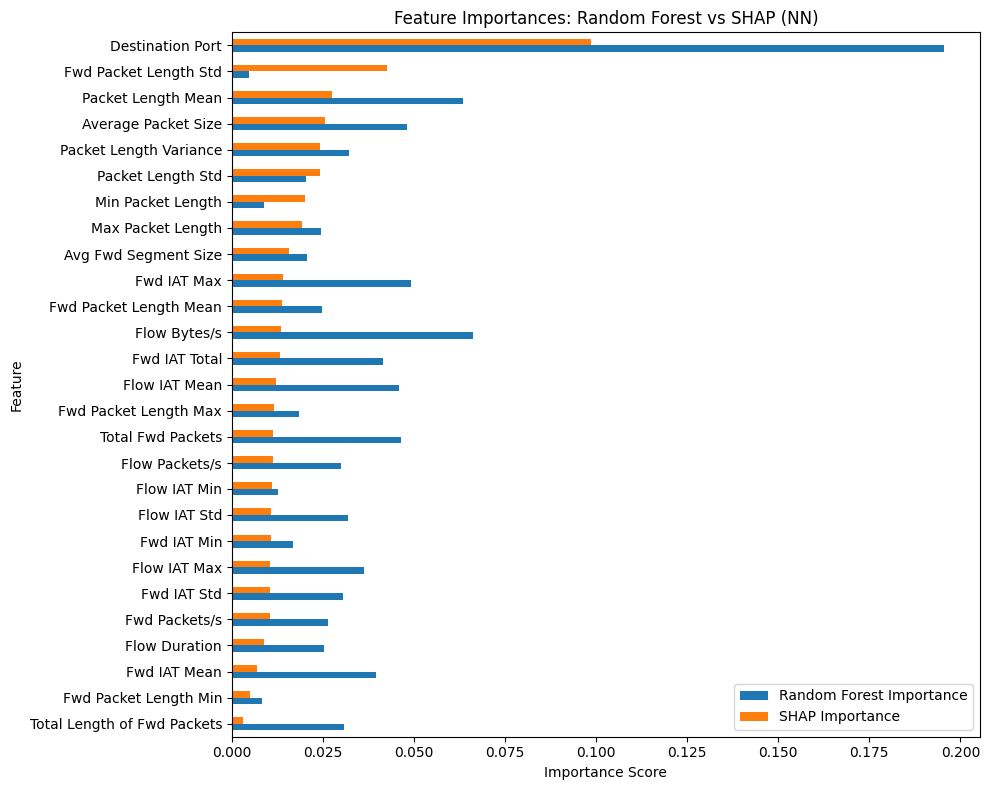

In [60]:
rf_importances = np.array(rf.feature_importances_).flatten()
shap_vals = shap_values.values  
shap_importance = np.abs(shap_vals).mean(axis=0).mean(axis=1)

assert len(rf_importances) == len(shap_importance) == x_train.shape[1]

# Create the comparison DataFrame
compare_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Random Forest Importance': rf_importances,
    'SHAP Importance': shap_importance
}).set_index('Feature')

# Sort and plot
compare_df = compare_df.sort_values('SHAP Importance', ascending=True)

compare_df.plot(kind='barh', figsize=(10, 8))
plt.title('Feature Importances: Random Forest vs SHAP (NN)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


## dest port to pred graph

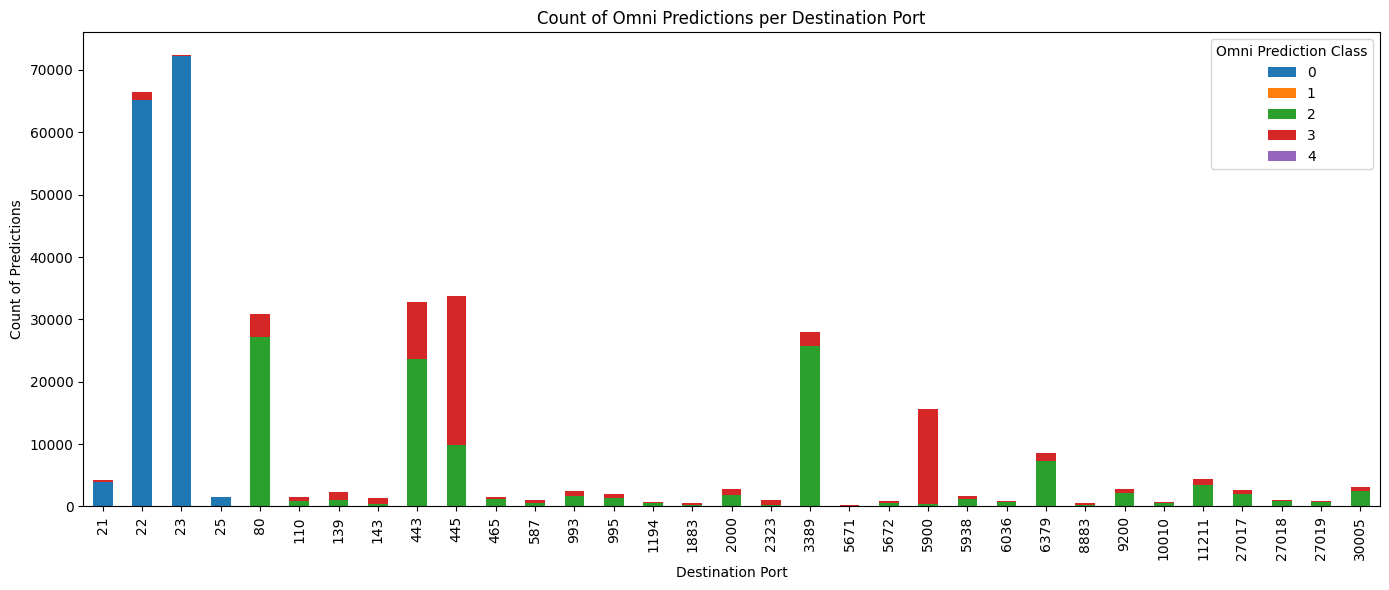

In [61]:
temp = grouped_df.copy()
temp['omni_pred'] = omni_pred

count_df = temp.groupby(['cic_Destination Port', 'omni_pred']).size().unstack(fill_value=0)

count_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.xlabel('Destination Port')
plt.ylabel('Count of Predictions')
plt.title('Count of Omni Predictions per Destination Port')
plt.legend(title='Omni Prediction Class')
plt.tight_layout()
plt.show()

## command analysis 

In [62]:
df_analysis = grouped_df.copy()
df_analysis['predicted_label'] = omni_pred
cmd_cols = [col for col in df_analysis.columns if col.startswith('cmd_')]

# Get proportions per class
binary_feature_means = df_analysis.groupby('predicted_label')[cmd_cols].mean() *100

label_map = {
    0: 'BruteForce',
    1: 'DoS/DDoS',
    2: 'Other',
    3: 'Scan',
    4: 'WebAttack'
}

binary_feature_means = binary_feature_means.rename(index=label_map)

print(binary_feature_means.round(2))

                 cmd_wget_max  cmd_curl_max  cmd_chmod_max  cmd_dd_max  \
predicted_label                                                          
BruteForce               0.00          0.38           0.00        0.61   
DoS/DDoS                 0.00          0.00           0.00        0.00   
Other                    0.23          0.06           0.18        1.84   
Scan                     0.10          0.89           0.08        0.26   
WebAttack                0.00          0.00           0.00        0.00   

                 cmd_http_over_ssh_max  cmd_scp_max  cmd_ftp_max  cmd_nc_max  \
predicted_label                                                                
BruteForce                        0.84         0.00         1.24        1.05   
DoS/DDoS                          0.00         0.00         0.00        0.00   
Other                             0.00         0.65         0.01        4.82   
Scan                              0.86         0.08         0.38        2.22   
W

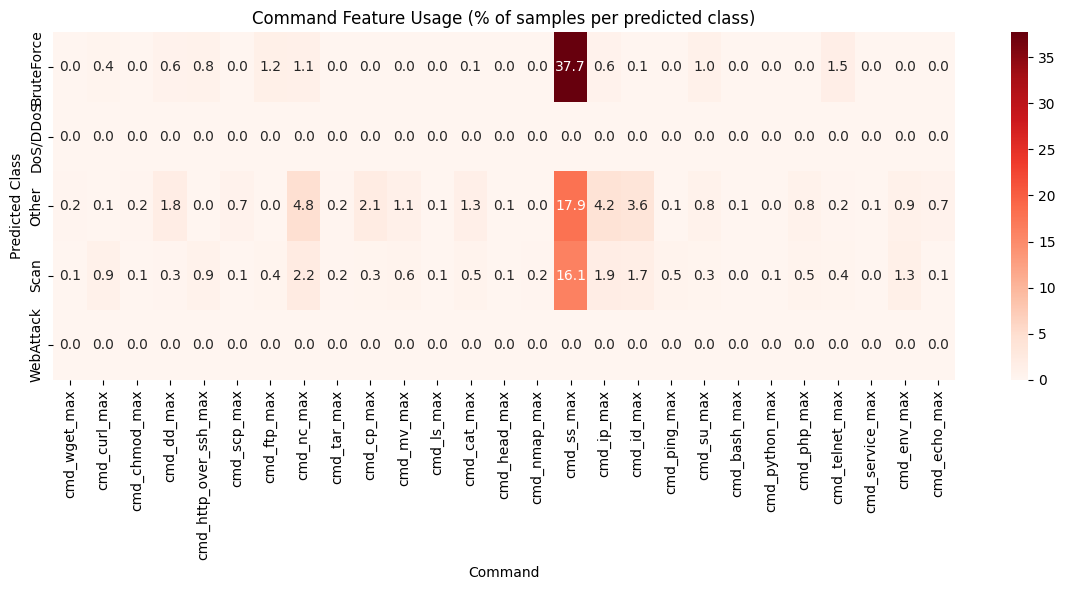

In [63]:
plt.figure(figsize=(12, 6))
sns.heatmap(binary_feature_means, annot=True, cmap="Reds", fmt=".1f")
plt.title("Command Feature Usage (% of samples per predicted class)")
plt.xlabel("Command")
plt.ylabel("Predicted Class")
plt.tight_layout()
plt.show()